In [5]:
import pickle
import os
import pickle
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from pandas.io import gbq
from google.cloud import bigquery
from google.oauth2 import service_account

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
% config InlineBackend . figure_format = 'svg'

In [7]:
## Set up bigquery environment

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/songlin/CS 224W/project/Github224W-c6c2551f3816.json"
project_id = 'github224w'
client = bigquery.Client(project=project_id)
dataset_id = 'gh_data'
dataset_ref = client.dataset(dataset_id)
dataset = client.get_dataset(dataset_ref)

/Users/songlin/anaconda2/envs/Python27/lib/python2.7/site-packages/urllib3/util/ssl_.py:150: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecurePlatformWarning
/Users/songlin/anaconda2/envs/Python27/lib/python2.7/site-packages/urllib3/util/ssl_.py:150: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. You can upgrade to a newer version of Python to solve this. For more information, see https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecurePlatformWarning
/Users/songlin/anaconda2/envs/Python27/lib/python2.7/site-packages/urllib3/util/ssl_.py:150: Insec

TransportError: HTTPSConnectionPool(host='oauth2.googleapis.com', port=443): Max retries exceeded with url: /token (Caused by SSLError(SSLError(1, '_ssl.c:504: error:0D0890A1:asn1 encoding routines:ASN1_verify:unknown message digest algorithm'),))

## Create a view for project commit times (All Times)

In [ ]:
view_ref = dataset_ref.table('project_commit_times_view')
view = bigquery.Table(view_ref)

view.view_query = """
#standardSQL
SELECT
  project_id,
  COUNT(commit_id) AS commit_times
FROM
  `ghtorrent-bq:ght_2018_04_01.project_commits`
GROUP BY
  project_id
"""
view = client.create_table(view)

In [14]:
## Retrieve data from the view
query_job = client.query("""
SELECT
  commit_times,
  COUNT(project_id) AS project_counts
FROM
  `github224w.gh_data.project_commit_times_view`
GROUP BY
  commit_times
    """)

results = query_job.result()
project_commit_counts = results.to_dataframe()

In [17]:
project_commit_counts.sort_values(by='commit_times', inplace=True)

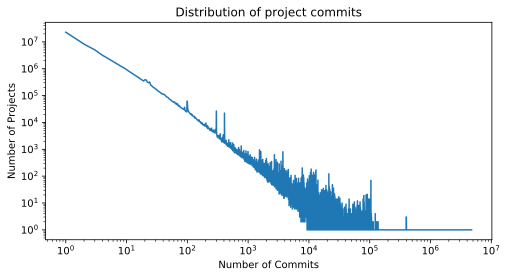

In [29]:
plt.figure(dpi=200, figsize=(8,4))
plt.plot(project_commit_counts['commit_times'], project_commit_counts['project_counts'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Commits')
plt.ylabel('Number of Projects')
plt.title('Distribution of project commits');

In [30]:
project_commit_counts['perc']=project_commit_counts['project_counts']*1.0/sum(project_commit_counts['project_counts'])
project_commit_counts['cum_sum'] = project_commit_counts['perc'].cumsum()

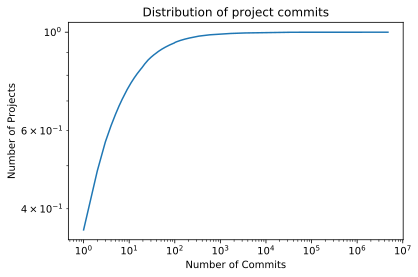

In [37]:
plt.plot(project_commit_counts['commit_times'], project_commit_counts['cum_sum'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Commits')
plt.ylabel('Accumulative percentage of perojects')
plt.title('Accumulated percentage of project based on commits');

## Create a view for project commit times (Since 2016)

In [40]:
view_ref = dataset_ref.table('project_commit_times_since_2016_view')
view = bigquery.Table(view_ref)
view.view_query = """
#standardsql
SELECT
  project_id,
  SUM(IF( created_at>TIMESTAMP('2016-01-01 00:00:00'),
      1,
      0 )) AS commit_since_2016
FROM
  `ghtorrent-bq.ght_2018_04_01.commits`
GROUP BY
  project_id
"""
view = client.create_table(view)

In [43]:
## Retrieve data from the view
query_job = client.query("""
SELECT
  commit_since_2016,
  COUNT(project_id) AS project_counts
FROM
  `github224w.gh_data.project_commit_times_since_2016_view`
GROUP BY
  commit_since_2016
    """)

results = query_job.result()
project_commit_counts_2016 = results.to_dataframe()

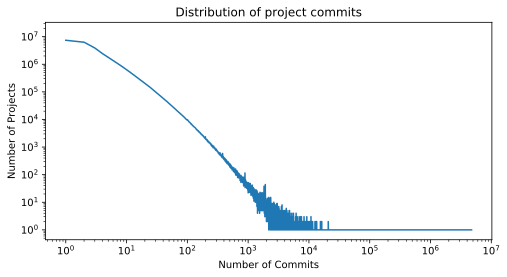

In [46]:
project_commit_counts_2016.sort_values(by='commit_since_2016', inplace=True)
plt.figure(dpi=200, figsize=(8,4))
plt.plot(project_commit_counts_2016['commit_since_2016'], project_commit_counts_2016['project_counts'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Commits')
plt.ylabel('Number of Projects')
plt.title('Distribution of project commits');

In [47]:
project_commit_counts_2016['perc']=project_commit_counts_2016['project_counts']*1.0/sum(project_commit_counts_2016['project_counts'])
project_commit_counts_2016['cum_sum'] = project_commit_counts_2016['perc'].cumsum()

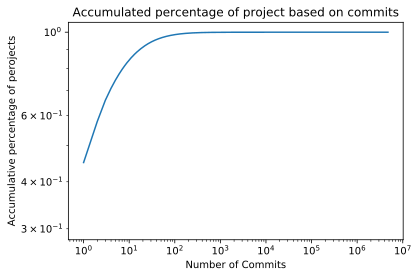

In [51]:
plt.plot(project_commit_counts_2016['commit_since_2016'], project_commit_counts_2016['cum_sum'])
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of Commits')
plt.ylabel('Accumulative percentage of perojects')
plt.title('Accumulated percentage of project based on commits');

## Check the projects with more than 100 commits since 2016 and associated with tag 'Python'

In [62]:
view_ref = dataset_ref.table('python_project_more_than_100_commits')
view = bigquery.Table(view_ref)
view.view_query = """
#standardsql
SELECT
  project_id
FROM
  `github224w.gh_data.project_commit_times_since_2016_view`
WHERE
  commit_since_2016 > 100
  AND project_id IN (
  SELECT
    DISTINCT project_id
  FROM
    `ghtorrent-bq.ght_2017_04_01.project_languages`
  WHERE
    LANGUAGE = 'python')
"""
view = client.create_table(view)

In [63]:
## Retrieve data from the view
query_job = client.query("""
SELECT
  project_id
FROM
  `github224w.gh_data.python_project_more_than_100_commits`
    """)

results = query_job.result()
python_projects = results.to_dataframe()

In [67]:
view_ref = dataset_ref.table('python_project_commiters')
view = bigquery.Table(view_ref)
view.view_query = """
#standardSQL
SELECT
  committer_id,
  project_id
FROM
  `ghtorrent-bq.ght_2017_04_01.commits`
WHERE
  created_at > TIMESTAMP('2016-01-01 00:00:00')
  AND project_id IN (
  SELECT
    project_id
  FROM
    `github224w.gh_data.python_project_more_than_100_commits`)
GROUP BY
  committer_id,
  project_id
"""
view = client.create_table(view)

In [68]:
## Retrieve data from the view
query_job = client.query("""
SELECT
  *
FROM
  `github224w.gh_data.python_project_commiters`
    """)

results = query_job.result()
python_commiters = results.to_dataframe()

In [115]:
commiter_counts = pd.DataFrame(python_commiters.groupby('project_id')['committer_id'].count())
commiter_counts.rename(columns={'committer_id':'committer_count'}, inplace=True)
commiter_value_counts = commiter_counts['committer_count'].value_counts()

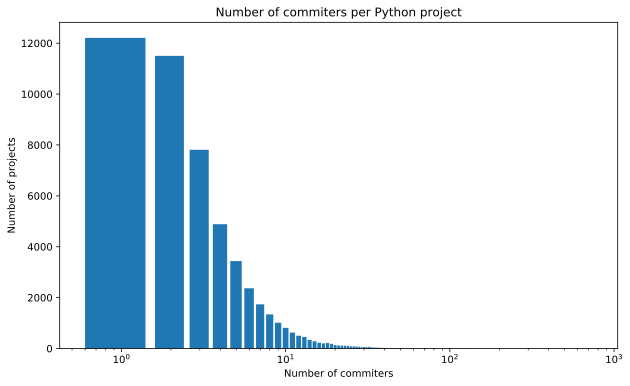

In [132]:
plt.figure(dpi=200, figsize=(10,6))
plt.bar(commiter_value_counts.index, commiter_value_counts.values)
plt.xscale('log')
plt.xlabel('Number of commiters')
plt.ylabel('Number of projects')
plt.title('Number of commiters per Python project');

In [155]:
print (f"Number of python projects with more than 100 commits since 2016: {commiter_counts.shape[0]}")
#print (f"Number of commiters counted by project: {commiter_counts['committer_count'].sum()}")
print (f"Number of unique commiters regardless of project: {len(python_commiters['committer_id'].unique())}")

Number of python projects with more than 100 commits since 2016: 52125
Number of unique commiters regardless of project: 151799


In [156]:
!pip freeze

absl-py==0.3.0
alabaster==0.7.10
anaconda-client==1.6.5
anaconda-navigator==1.6.9
anaconda-project==0.8.0
appnope==0.1.0
appscript==1.0.1
asn1crypto==0.22.0
astor==0.7.1
astroid==1.5.3
astropy==2.0.2
Babel==2.5.0
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.6.0
bitarray==0.8.1
bkcharts==0.2
blaze==0.11.3
bleach==2.0.0
bokeh==0.13.0
boto==2.48.0
boto3==1.7.62
botocore==1.10.62
Bottleneck==1.2.1
cachetools==2.1.0
certifi==2018.8.13
cffi==1.10.0
chardet==3.0.4
click==6.7
cloudpickle==0.4.0
clyent==1.2.2
colorama==0.3.9
contextlib2==0.5.5
cryptography==2.0.3
cycler==0.10.0
Cython==0.26.1
cytoolz==0.8.2
dask==0.15.3
datashape==0.5.4
decorator==4.1.2
distributed==1.19.1
docutils==0.14
emoji==0.5.0
entrypoints==0.2.3
et-xmlfile==1.0.1
fastcache==1.0.2
filelock==2.0.12
Flask==0.12.2
Flask-Cors==3.0.3
gast==0.2.0
gensim==3.4.0
gevent==1.2.2
glob2==0.5
gmpy2==2.0.8
google-api-core==1.3.0
google-auth==1.5.1
google-auth-oauthlib==0.2.0
google-cloud==0.34.0
google-cloud-bigquery==1.5

## Select the projects with more than 5 commiters

In [133]:
view_ref = dataset_ref.table('python_project_more_than_5_commiters')
view = bigquery.Table(view_ref)
view.view_query = """
#standardSQL
SELECT
  project_id
FROM (
  SELECT
    committer_id,
    project_id
  FROM
    `ghtorrent-bq.ght_2017_04_01.commits`
  WHERE
    created_at > TIMESTAMP('2016-01-01 00:00:00')
    AND project_id IN (
    SELECT
      project_id
    FROM
      `github224w.gh_data.python_project_more_than_100_commits`)
  GROUP BY
    committer_id,
    project_id)
GROUP BY
  project_id
HAVING
  COUNT(committer_id) >= 5
"""
view = client.create_table(view)

In [152]:
## Retrieve data from the view
query_job = client.query("""
#standardSQL
SELECT
  project_id,
  author_id,
  committer_id
FROM
  `ghtorrent-bq.ght_2017_04_01.commits`
WHERE
  created_at > TIMESTAMP('2016-01-01 00:00:00') AND
  project_id IN(
  SELECT
    *
  FROM
    `github224w.gh_data.python_project_more_than_5_commiters`)
GROUP BY
  project_id,
  author_id,
  committer_id
    """)

results = query_job.result()
python_more_5_commiters = results.to_dataframe()

In [154]:
print (f"Number of python projects with more than 5 commiters: {len(python_more_5_commiters['project_id'].unique())}")
print (f"Number of unique commiters regardless of project: {len(python_more_5_commiters['committer_id'].unique())}")

Number of python projects with more than 5 commiters: 15719
Number of unique commiters regardless of project: 115113


In [151]:
python_more_5_commiters.groupby('project_id')[['committer_id']].count()

,committer_id
project_id,
6,795
19,28
29,403
63,85
71,599
159,232
202,1975
252,45
284,915
